# TensorRT

In [1]:
import pathlib
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

# How to create the docker run directly in Lambda2
# docker run --gpus all -it --mount type=bind,source=/home/jacob-delgado/Documents/CAPSTONE,target=/workspace/CAPSTONE nvcr.io/nvidia/tensorflow:24.10-tf2-py3

2024-11-14 01:23:14.495955: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 01:23:14.531076: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Benchmarking

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4244699710166956715
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23077453824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 618463580213304651
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:82:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


2024-11-14 01:23:15.845548: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-14 01:23:15.881959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-14 01:23:15.882149: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
print(trt.trt_utils._pywrap_py_utils.get_linked_tensorrt_version())

(10, 5, 0)


### Benchmarking

In [14]:
data_root = pathlib.Path("../data/Monkeypox_Data/Original_Images")    # points to the folder containing the images that will be used for training
saved_model_dir = '../best_model/model1/best_f1score_fold'
fp32_optimized_model_dir = '../tensorRT_model/fp32'
fp16_optimized_model_dir = '../tensorRT_model/fp16'
int8_optimized_model_dir = '../tensorRT_model/int8'

# hyperparameters
batch_size = 32         # size of the batch that will be fed to model
img_height = 224        # input image height
img_width = 224         # input image width
test_size = 0.2

# Load dataset without splitting
dataset = tf.keras.utils.image_dataset_from_directory(
    data_root,                                  # loads images from the data_root directory
    image_size=(img_height, img_width),         # resizes all images to (224, 224) pixels
    batch_size=batch_size,                      # set the batch size
    shuffle=False                                # shufle data when loaded
)

# normalization_layer = layers.Rescaling(1./255)
# dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

Found 228 files belonging to 2 classes.


### Inference and Metrics Setup

In [15]:
image_batches, labels = [], []
for image_batch, label_batch in dataset:
    image_batches.append(image_batch)
    labels.append(label_batch)

image_batches = np.concatenate(image_batches) # Flatten batches to get all images
labels = np.concatenate(labels)               # Flatten batches to get all labels  
print(f"Total Images: {image_batches.shape[0]} \nTotal Labels: {labels.shape[0]}")

# Split the data into test subset for benchmarking
_, X_test, _, Y_test = train_test_split(image_batches, labels, test_size=test_size, random_state=42)


X_test = X_test / 255.0


Total Images: 228 
Total Labels: 228


2024-11-14 01:27:47.509431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Model Size Difference

In [16]:
def get_model_size(model_dir):
    total_size = 0
    for dirpath, _, filenames in os.walk(model_dir):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size / (1024 * 1024)  # Convert to MB

# original_size = get_model_size(saved_model_dir)
# optimized_size = get_model_size(optimized_model_dir)
# print(f"Original Model Size: {original_size:.2f} MB")
# print(f"Optimized Model Size: {optimized_size:.2f} MB")
# print(f"Compression Ratio: {original_size / optimized_size:.2f}")


In [17]:
import os
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

### Run Inference on Models

In [ ]:
def measure_inference_time(model, X_test, batch_size, trials=500):
    inference_times = []

    num_batches = len(X_test) // batch_size

    # Warm-up phase (Run a few trials to initialize the model)
    print(f"Running {50} warm-up trials to initialize the model...")
    for _ in range(50):
        for j in range(num_batches):
            batch_start = j * batch_size
            batch_end = (j + 1) * batch_size
            batch_images = X_test[batch_start:batch_end]  # Get a batch of images
            dummy_input = tf.convert_to_tensor(batch_images) # Ensure the batch is in tensor format
            model.signatures["serving_default"](tf.convert_to_tensor(dummy_input))
            tf.keras.backend.clear_session()

    print(f"Running {trials} inference trials on {len(X_test)} test images...")
    for i in range(trials):
        start_time = time.perf_counter()

        # Loop over the batches of X_test
        for j in range(num_batches):
            batch_start = j * batch_size
            batch_end = (j + 1) * batch_size
            batch_images = X_test[batch_start:batch_end]  # Get a batch of images
            inputs = tf.convert_to_tensor(batch_images) # Ensure the batch is in tensor format

            # Run inference for the batch
            model.signatures["serving_default"](inputs)  # Perform inference directly
            tf.keras.backend.clear_session()

        end_time = time.perf_counter()
        inference_time = end_time - start_time
        inference_times.append(inference_time)

        if i % 100 == 0:
            avg_inference = np.mean(inference_times)  # Average inference time per trial
            print(f"Step {i}: average inference time = {avg_inference:.6f} seconds")

    tf.keras.backend.clear_session() # Clear to avoid over-allocating memory

    # Compute throughput (images per second)
    total_time = np.sum(inference_times)
    throughput = (trials * len(X_test)) / total_time
    return np.mean(inference_times), throughput

### Run Metrics on Models

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_metrics(model, X_test, Y_test, batch_size):
    print(f"Evaluating metrics on {len(X_test)} test images...")
    
    num_batches = len(X_test) // batch_size
    all_predicted_classes = []

    # Loop over the test dataset in batches
    for j in range(num_batches):
        batch_start = j * batch_size
        batch_end = (j + 1) * batch_size
        batch_images = X_test[batch_start:batch_end]
        inputs = tf.convert_to_tensor(batch_images)  # Convert batch to tensor

        # Run predictions
        result = model.signatures["serving_default"](inputs)  # Inference
        prediction_logits = result["output_0"].numpy()  # Extract logits
        probabilities = tf.nn.sigmoid(prediction_logits).numpy()  # Apply sigmoid
        predicted_classes = (probabilities > 0.5).astype(int)  # Threshold for binary classification

        # Collect predictions
        all_predicted_classes.extend(predicted_classes)

    # Handle any remaining images that don't fit evenly in batches
    remaining_samples = len(X_test) % batch_size
    if remaining_samples > 0:
        batch_images = X_test[-remaining_samples:]
        inputs = tf.convert_to_tensor(batch_images)
        result = model.signatures["serving_default"](inputs)
        prediction_logits = result["output_0"].numpy()
        probabilities = tf.nn.sigmoid(prediction_logits).numpy()
        predicted_classes = (probabilities > 0.5).astype(int)
        all_predicted_classes.extend(predicted_classes)

    # Flatten predictions and labels to ensure they are 1D arrays
    all_predicted_classes = np.array(all_predicted_classes).flatten()
    Y_test = np.array(Y_test).flatten()

    # Ensure the number of predictions matches the number of ground truth labels
    if len(all_predicted_classes) != len(Y_test):
        raise ValueError(f"Number of predicted classes ({len(all_predicted_classes)}) "
                         f"does not match the number of ground truth labels ({len(Y_test)}).")

    # Calculate metrics
    accuracy = accuracy_score(Y_test, all_predicted_classes)
    precision = precision_score(Y_test, all_predicted_classes, average="binary")
    recall = recall_score(Y_test, all_predicted_classes, average="binary")
    f1 = f1_score(Y_test, all_predicted_classes, average="binary")

    # Output metrics
    metrics_dict = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }

    print(f"Metrics: {metrics_dict}")
    return metrics_dict

### Perform Benchmarking

In [11]:
# List of models and their directories
models = ["Original", "FP32", "FP16", "INT8"]
model_dirs = [saved_model_dir, fp32_optimized_model_dir, fp16_optimized_model_dir, int8_optimized_model_dir]

# Initialize storage for results
model_sizes = {}
average_times = {}
throughputs = {}
metrics = {}

# Load models and gather data
for model_name, model_dir in zip(models, model_dirs):
    # Get model size
    model_sizes[model_name] = get_model_size(model_dir)
    
    # Load the model
    model = tf.saved_model.load(model_dir)
    
    # Measure inference time and throughput
    print(f'Checking inference time for {model_name} model')
    avg_time, throughput = measure_inference_time(model, X_test, batch_size=batch_size)
    average_times[model_name] = avg_time
    throughputs[model_name] = throughput
    
    # Measure metrics
    metrics[model_name] = measure_metrics(
        model=model,
        X_test=X_test,
        Y_test=Y_test,
        batch_size=batch_size,
    )

# Calculate compression ratios and speedup factors
compression_ratios = {
    model: model_sizes["Original"] / size
    for model, size in model_sizes.items() if model != "Original"
}

speedup_factors = {
    model: average_times["Original"] / time
    for model, time in average_times.items() if model != "Original"
}

# Print results
print("\nModel Sizes (in MB):")
for model, size in model_sizes.items():
    print(f"{model:<6}: {size:.2f} MB")

print("\nCompression Ratios:")
for model, ratio in compression_ratios.items():
    print(f"{model:<6}: {ratio:.2f}")

print("\nInference Times (seconds):")
for model, avg_time in average_times.items():
    print(f"{model:<6}: {avg_time:.6f}")

print("\nThroughputs (images/second):")
for model, throughput in throughputs.items():
    print(f"{model:<6}: {throughput:.2f}")

print("\nSpeedup Factors:")
for model, speedup in speedup_factors.items():
    print(f"{model:<6}: {speedup:.2f}")

# Compare metrics
print("\nMetrics Comparison:")
metric_keys = next(iter(metrics.values())).keys()  # Get metric keys from any model's results
print(f"{'Metric':<12} " + " ".join([f"{model:<12}" for model in models]))
print("-" * (12 + 12 * len(models)))

for metric in metric_keys:
    values = [metrics[model][metric] for model in models]
    values_str = " ".join([f"{value:<12.4f}" for value in values])
    print(f"{metric:<12} {values_str}")


Checking inference time for Original model
Running 50 warm-up trials to initialize the model...


2024-11-14 01:23:19.520023: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 90500


Running 500 inference trials on 46 test images...
Step 0: average inference time = 0.201512 seconds
Step 100: average inference time = 0.205449 seconds
Step 200: average inference time = 0.203849 seconds
Step 300: average inference time = 0.200200 seconds
Step 400: average inference time = 0.198768 seconds
Evaluating metrics on 46 test images...
Metrics: {'accuracy': 0.9782608695652174, 'precision': 0.967741935483871, 'recall': 1.0, 'f1_score': 0.9836065573770492}
Checking inference time for FP32 model
Running 50 warm-up trials to initialize the model...


2024-11-14 01:25:16.847908: I tensorflow/compiler/tf2tensorrt/common/utils.cc:120] Linked TensorRT version: 10.5.0
2024-11-14 01:25:16.847930: I tensorflow/compiler/tf2tensorrt/common/utils.cc:122] Loaded TensorRT version: 10.5.0
2024-11-14 01:25:18.822251: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1382] [TF-TRT] Sparse compute capability: enabled.


Running 500 inference trials on 46 test images...
Step 0: average inference time = 0.048251 seconds
Step 100: average inference time = 0.044434 seconds
Step 200: average inference time = 0.044480 seconds
Step 300: average inference time = 0.044185 seconds
Step 400: average inference time = 0.044369 seconds
Evaluating metrics on 46 test images...
Metrics: {'accuracy': 0.9782608695652174, 'precision': 0.967741935483871, 'recall': 1.0, 'f1_score': 0.9836065573770492}
Checking inference time for FP16 model
Running 50 warm-up trials to initialize the model...


2024-11-14 01:25:57.498172: W tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:971] TF-TRT Warning: Engine retrieval for input shapes: [[14,224,224,3]] failed. Running native segment for PartitionedCall/TRTEngineOp_000_000
2024-11-14 01:25:59.487342: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:83] TF-TRT Warning: DefaultLogger IElementWiseLayer with inputs StatefulPartitionedCall/sequential_1_1/mobilenetv2_1.00_224_1/bn_Conv1_1/batchnorm/mul_1 and PartitionedCall/TRTEngineOp_001_000/_tftrt_constant_-0:CONSTANT_output: first input has type Float but second input has type Half.
2024-11-14 01:25:59.487420: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:83] TF-TRT Warning: DefaultLogger IElementWiseLayer with inputs StatefulPartitionedCall/sequential_1_1/mobilenetv2_1.00_224_1/expanded_conv_depthwise_1/depthwise and PartitionedCall/TRTEngineOp_001_000/_tftrt_constant_-1:CONSTANT_output: first input has type Float but second input has type Half.
2024-11-14 01:25:59.

Running 500 inference trials on 46 test images...
Step 0: average inference time = 0.050435 seconds
Step 100: average inference time = 0.047081 seconds
Step 200: average inference time = 0.047591 seconds
Step 300: average inference time = 0.047936 seconds
Step 400: average inference time = 0.047937 seconds
Evaluating metrics on 46 test images...


2024-11-14 01:27:01.623305: W tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:971] TF-TRT Warning: Engine retrieval for input shapes: [[14,224,224,3]] failed. Running native segment for PartitionedCall/TRTEngineOp_001_000
2024-11-14 01:27:01.641498: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Metrics: {'accuracy': 0.9782608695652174, 'precision': 0.967741935483871, 'recall': 1.0, 'f1_score': 0.9836065573770492}
Checking inference time for INT8 model
Running 50 warm-up trials to initialize the model...


2024-11-14 01:27:01.917988: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:83] TF-TRT Warning: DefaultLogger Using an engine plan file across different models of devices is not recommended and is likely to affect performance or even cause errors.
2024-11-14 01:27:01.979150: W tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:971] TF-TRT Warning: Engine retrieval for input shapes: [[32,224,224,3]] failed. Running native segment for PartitionedCall/TRTEngineOp_002_000
2024-11-14 01:27:02.202723: W tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:971] TF-TRT Warning: Engine retrieval for input shapes: [[32,224,224,3]] failed. Running native segment for PartitionedCall/TRTEngineOp_002_000
2024-11-14 01:27:02.295825: W tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:971] TF-TRT Warning: Engine retrieval for input shapes: [[32,224,224,3]] failed. Running native segment for PartitionedCall/TRTEngineOp_002_000


Running 500 inference trials on 46 test images...
Step 0: average inference time = 0.079859 seconds
Step 100: average inference time = 0.081416 seconds
Step 200: average inference time = 0.080465 seconds
Step 300: average inference time = 0.080600 seconds
Step 400: average inference time = 0.081103 seconds
Evaluating metrics on 46 test images...
Metrics: {'accuracy': 0.9782608695652174, 'precision': 0.967741935483871, 'recall': 1.0, 'f1_score': 0.9836065573770492}

Model Sizes (in MB):
Original: 18.90 MB
FP32  : 8.53 MB
FP16  : 4.32 MB
INT8  : 7.76 MB

Compression Ratios:
FP32  : 2.22
FP16  : 4.38
INT8  : 2.44

Inference Times (seconds):
Original: 0.199969
FP32  : 0.044619
FP16  : 0.047922
INT8  : 0.081526

Throughputs (images/second):
Original: 230.04
FP32  : 1030.95
FP16  : 959.89
INT8  : 564.23

Speedup Factors:
FP32  : 4.48
FP16  : 4.17
INT8  : 2.45

Metrics Comparison:
Metric       Original     FP32         FP16         INT8        
------------------------------------------------

### Metrics

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example Data (Replace with your actual data)
models = ["Original", "FP32", "FP16", "INT8"]
model_sizes_data = [model_sizes[model] for model in models]
throughputs_data = [throughputs[model] for model in models]
average_times_data = [average_times[model] for model in models]

# Dictionary to store metrics for all models
metrics_data = {model: metrics[model] for model in models}

# Prepare DataFrames for sizes and throughputs
model_sizes_df = pd.DataFrame({
    "Model": models,
    "Size (MB)": model_sizes_data
})

throughputs_df = pd.DataFrame({
    "Model": models,
    "Throughput (images/second)": throughputs_data
})

average_times_df = pd.DataFrame({
    "Model": models,
    "Average Inference Time (Seconds)": average_times_data
})

# Function to plot model sizes
def graph_model_size(model_sizes):
    plt.figure(figsize=(8, 5))
    blue_palette = sns.color_palette("Blues", n_colors=len(model_sizes))
    ax = sns.barplot(data=model_sizes, x="Model", y="Size (MB)", palette=blue_palette)
    plt.title("Model Sizes Comparison")
    plt.ylabel("Size (MB)")
    plt.xlabel("Model")

    # Set y-axis ticks to increment by 0.5
    max_size = model_sizes["Size (MB)"].max()
    plt.yticks(np.arange(0, max_size + 1, 1))
    
    # Annotate each bar with its height
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height(),
            f'{p.get_height():.4f}',
            ha='center', va='bottom', fontsize=10
        )
    plt.tight_layout()
    plt.savefig("../tensorRT_model/metrics/model_sizes.png")
    plt.show()

# Function to plot throughputs
def graph_throughput(throughputs):
    plt.figure(figsize=(8, 5))
    blue_palette = sns.color_palette("Blues", n_colors=len(throughputs))
    ax = sns.barplot(data=throughputs, x="Model", y="Throughput (images/second)", palette=blue_palette)
    plt.title("Model Throughput Comparison")
    plt.ylabel("Throughput (images/second)")
    plt.xlabel("Model")

    # Set y-axis ticks to increment by 10
    max_throughput = throughputs["Throughput (images/second)"].max()
    plt.yticks(range(0, int(max_throughput) + 10, 10))
    
    # Annotate each bar with its height
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height(),
            f'{p.get_height():.4f}',
            ha='center', va='bottom', fontsize=10
        )
    plt.tight_layout()
    plt.savefig("../tensorRT_model/metrics/throughput_comparison.png")
    plt.show()

# Function to plot average inference times
def graph_inference_times(average_times_df):
    plt.figure(figsize=(8, 5))
    blue_palette = sns.color_palette("Blues", n_colors=len(average_times_df))
    ax = sns.barplot(data=average_times_df, x="Model", y="Average Inference Time (Seconds)", palette=blue_palette)
    plt.title("Average Inference Time Comparison")
    plt.ylabel("Inference Time (Seconds)")
    plt.xlabel("Model")

    # Set y-axis ticks to increment by 0.1
    max_times = average_times_df["Average Inference Time (Seconds)"].max()
    plt.yticks(np.arange(0, max_times + 0.1, 0.1))

    # Annotate each bar with its height
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height(),
            f'{p.get_height():.4f}',
            ha='center', va='bottom', fontsize=10
        )
    plt.tight_layout()
    plt.savefig("../tensorRT_model/metrics/average_inference_comparison.png")
    plt.show()

# Function to compare metrics across models
def graph_metrics(metrics_data):
    # Convert metrics data into a DataFrame
    metrics_df = pd.DataFrame(metrics_data).T.reset_index()
    metrics_df = metrics_df.rename(columns={"index": "Model"})

    # Melt for plotting
    metrics_long = pd.melt(
        metrics_df, id_vars=["Model"], 
        var_name="Metric", value_name="Value"
    )

    # Grouped Bar Chart for Metrics
    plt.figure(figsize=(14, 6))
    blue_palette = sns.color_palette("Blues", n_colors=len(metrics_data))
    ax = sns.barplot(data=metrics_long, x="Metric", y="Value", hue="Model", palette=blue_palette)
    plt.title("Metrics Comparison")
    plt.ylabel("Value")
    plt.xlabel("Metric")

    # Set y-axis ticks to increment by 0.1
    plt.yticks(np.arange(0, 1.1, 0.1))
    
    # Annotate each bar with its height
    for p in ax.patches:
        if p.get_height()>0:
            ax.text(
                p.get_x() + p.get_width() / 2,
                p.get_height(),
                f'{p.get_height():.4f}',
                ha='center', va='bottom', fontsize=10
            )
    plt.legend(title="Model", bbox_to_anchor=(1.05,1),loc="upper left")
    plt.tight_layout(pad=2)
    plt.savefig("../tensorRT_model/metrics/metrics_comparison.png")
    plt.show()

    print("\nDetailed Metric Changes:")
    print(metrics_df)

/tmp/ipykernel_12624/2250158058.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_sizes, x="Model", y="Size (MB)", palette="muted")


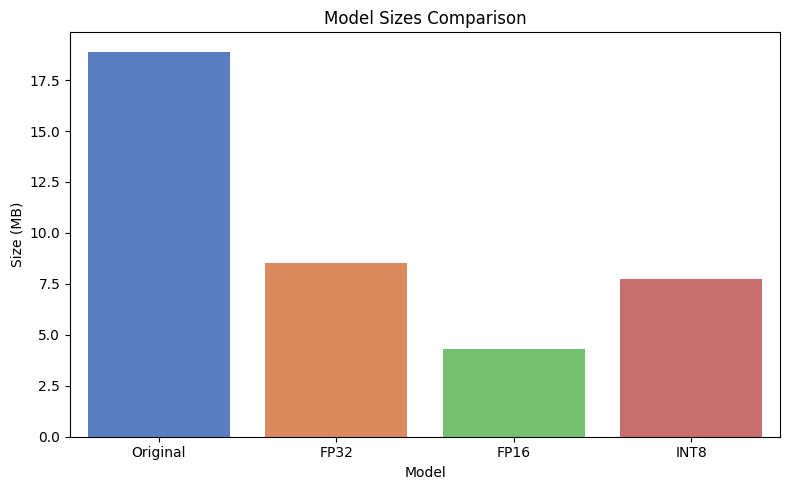

/tmp/ipykernel_12624/2250158058.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=throughputs, x="Model", y="Throughput (images/second)", palette="muted")


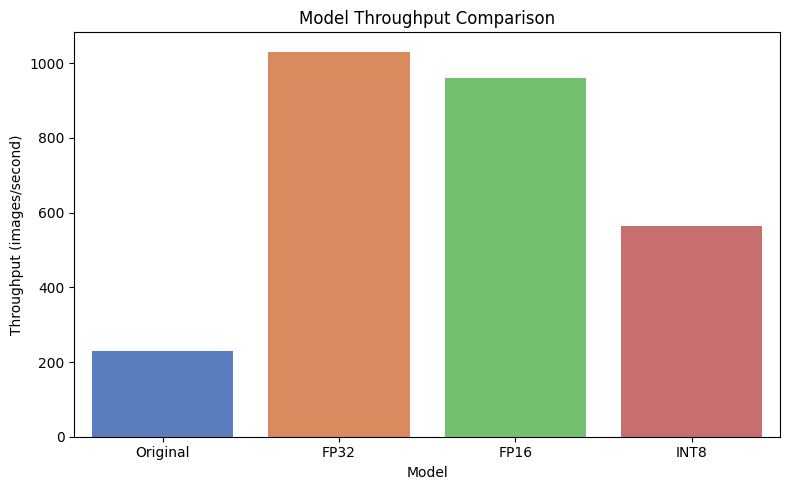

/tmp/ipykernel_12624/2250158058.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_times_df, x="Model", y="Average Inference Time (Seconds)", palette="muted")


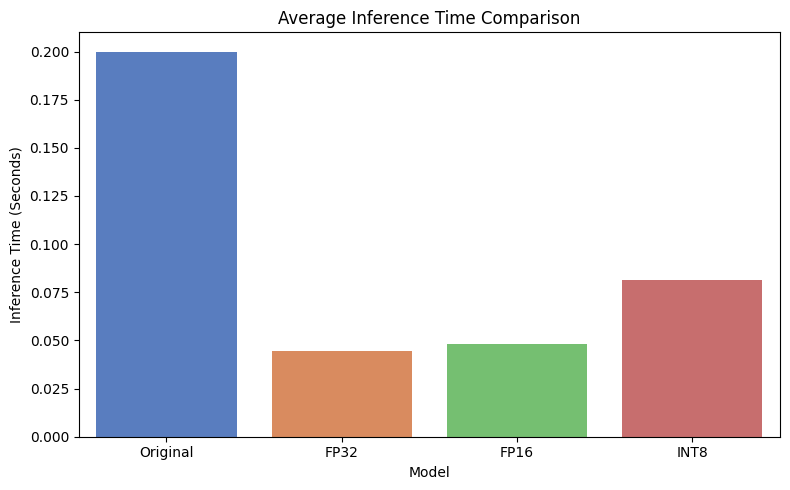

In [ ]:
graph_model_size(model_sizes_df)  
graph_throughput(throughputs_df)  
graph_inference_times(average_times_df)
graph_metrics(metrics_data)  